In [38]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random #generating negative random numbers

from mpl_toolkits.mplot3d import Axes3D # for 3D visualization

from tqdm import tqdm, trange #loading status


## Dendpoint generation in 2D

In [2]:
Ldend = 180
soma = np.zeros(3)
soma= np.array([-150,-300,0])

DEBUG=False

def debug_print(*s):
    if DEBUG:
        print(*s)
    else:
        pass

def make_random_dend_ends():
    angle0 = np.random.rand()*np.pi/2
    debug_print("Starting Point",angle0) #random starting point
    # first 3 angles between dends
    angles3 = np.ones(3)*np.pi/2
    angles = np.cumsum(angles3) 
    angles = np.hstack([0, angles]) + angle0 

    #adding more variability for each point independent from the others
    r=np.random.uniform(-0.5, 0.5,4)
    angles=angles+r
    debug_print("Single Point Variation=", r)

    #produce x and y coordinates
    return np.array([[Ldend*np.cos(a), Ldend*np.sin(a)] for a in angles]) # cos=x; sin=y
    
point1_xz = make_random_dend_ends()               
print(point1_xz)

print(soma)
point1_xz = point1_xz + soma[:2]               

print(point1_xz)




[[  93.96689078  153.52596991]
 [-102.29000703  148.11061563]
 [-119.59885051 -134.52180105]
 [ 126.89701978 -127.66027719]]
[-150 -300    0]
[[ -56.03310922 -146.47403009]
 [-252.29000703 -151.88938437]
 [-269.59885051 -434.52180105]
 [ -23.10298022 -427.66027719]]


In [3]:
#circle
theta = np.linspace( 0 , 2 * np.pi , 170 )  
radius = Ldend #ToDO automate: point -soma?
Ca = radius * np.cos( theta )+soma[0]
Cb = radius * np.sin( theta )+soma[1]

In [4]:
# upper and lower borders (y= mx+n)
xlay=np.linspace(-500,150,150)
upperLimit=-250 #MLI layer border
lowerLimit=-75 #MLI layer border
up=0*xlay+upperLimit
down=0*xlay+lowerLimit

In [5]:
##Check if upper layer limit collides with dendrite radius around soma
#calculate distance between layer and soma
d=abs(soma[1]-upperLimit)
print(d)
if d < radius:
    print("Dendrites might interfere with layer limit")
elif d <= radius:
    print("Dendrites might reach layer limit")
else:
    print("There is enough space for dendrites")



50
Dendrites might interfere with layer limit


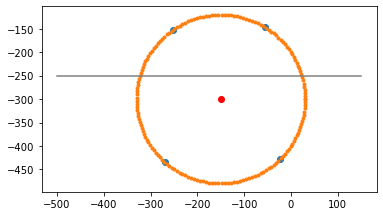

In [6]:
#plot
figure, axes= plt.subplots(1)

axes.plot(point1_xz[:,0], point1_xz[:,1], 'o')
axes.plot(soma[0],soma[1], 'or')

axes.plot(Ca,Cb, ".")
axes.plot(xlay,up, "grey")
#axes.plot(xlay,down, "grey")
axes.set_aspect(1)

In [7]:
#check which dendrite is outside of the layer and correct its position
def fix_dend_ends_upper(point1_xz, soma, upperLimit, push_down=100):
    
    d=abs(soma[1]-upperLimit)
    
    point1_xz_new = np.zeros_like(point1_xz)
    for i in range(point1_xz.shape[0]):
        x, y=point1_xz[i];
        
        #print(point1_xz[i]);
        if y>soma[1]+d:
            debug_print("Dendrite",i, "is outside the layer:", point1_xz[i]);
            if point1_xz[i,0]< soma[0]:       # make sure each dendrite goes to one one side
                y=soma[1]+d- np.random.uniform(0, push_down); #soma y coord. plus the distance to layer+ variability 
                point1_xz_new[i,1]=y
                phi=np.arcsin((y-soma[1])/radius) # calculate phi for new x
                x1=radius*np.cos(phi)+soma[0]     # new x coord. on layer
                point1_xz_new[i,0]=soma[0]-(x1-soma[0]) 
            else:
                y=soma[1]+d- np.random.uniform(0, push_down); #soma y coord. plus the distance to layer
                phi=np.arcsin((y-soma[1])/radius) # calculate phi for new x
                x1=radius*np.cos(phi)+soma[0]     # new x coord. on layer
                point1_xz_new[i,:]=[x1, y]
            debug_print("New Coordinates", point1_xz[i])
        else:
            debug_print("Dendrite",i, "is inside the layer ")
            point1_xz_new[i,:]= [x, y]

    return point1_xz_new


point1_xz_new = fix_dend_ends_upper(point1_xz, soma, -250)

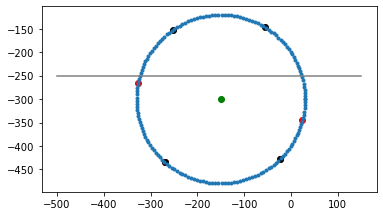

In [8]:
#plot
figure, axes= plt.subplots(1)

axes.plot(point1_xz_new[:,0], point1_xz_new[:,1], 'or')
axes.plot(point1_xz[:,0], point1_xz[:,1], 'ok')
axes.plot(soma[0],soma[1], 'og')
axes.plot(Ca,Cb, ".")
axes.plot(xlay,up, "grey")
#axes.plot(xlay,down, "grey")
axes.set_aspect(1)

Add points between Soma and EndPoint

In [9]:
#calculate x values for points between soma and endpoint
#xDendAll=np.empty((0,0), dtype=object)
def dend_points_soma_endpoint(point1_xz_new, soma, nPoint=90):
    xDendAll = np.zeros(shape=(0))
    yDendAll = np.zeros(shape=(0))
    for i in range(point1_xz_new.shape[0]):
        #nPoint= 90
        xLen=abs(soma[0]-point1_xz_new[i,0]) # length of dendrite on x axis
        xComp= xLen/nPoint # distance of compartments on x axis
        if point1_xz_new[i,0] < soma[0]:
            xDend=(np.cumsum(np.ones(nPoint-1)*xComp))+ point1_xz_new[i,0]#soma[0]
            xDendAll = np.append(xDendAll, xDend, axis=0)
        else:
            xDend=(np.cumsum(np.ones(nPoint-1)*xComp))+soma[0]
            xDendAll = np.append(xDendAll, xDend, axis=0)
        #calculating slope
        m=(soma[1]-point1_xz_new[i,1])/(soma[0]-point1_xz_new[i,0]) #m=(y1-y2)/(x1-x2)
        #function for calculating y
        yDend=np.array((m*xDend)-(m*soma[0])+soma[1])
        
        yDendAll = np.append(yDendAll, yDend, axis=0)
    
    return xDendAll, yDendAll
        
xDendAll,yDendAll = dend_points_soma_endpoint(point1_xz_new, soma)


#TODO: case for vertical line?

    


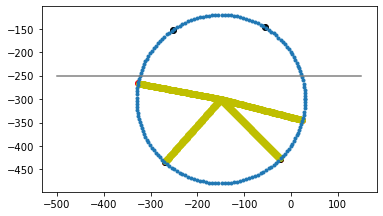

In [10]:
#plot
figure, axes= plt.subplots(1)

axes.plot(point1_xz_new[:,0], point1_xz_new[:,1], 'or')
axes.plot(point1_xz[:,0], point1_xz[:,1], 'ok')
axes.plot(soma[0],soma[1], 'og')
axes.plot(xDendAll[:],yDendAll[:],'oy')
axes.plot(Ca,Cb, ".")
axes.plot(xlay,up, "grey")
#axes.plot(xlay,down, "grey")
axes.set_aspect(1)

ADD MORE SOMA

In [11]:
soma = np.zeros((60,3))
somas = np.array([np.random.uniform(-600,600,3) for i in soma]) # cos=x; sin=y
somas[:,0] = np.random.uniform(-600, 600, size=60)
somas[:,1] = np.random.uniform(20, 180, size=60)


print("We generated", len(somas), "somas.")

We generated 60 somas.


In [12]:
# upper and lower borders (y= mx+n)
xlay=np.linspace(-600,600,600)
upperLimit=max(somas[:,1])+20 #MLI layer border
lowerLimit=min(somas[:,1]-20) #MLI layer border

#upperLimit= 200 #MLI layer border
up=0*xlay+upperLimit
down=0*xlay+lowerLimit

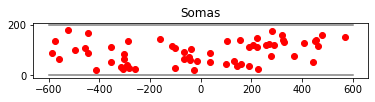

In [13]:
figure, axes= plt.subplots(1)

#axes.plot(point1_xz[:,0], point1_xz[:,1], 'o')
#axes.plot(Ca,Cb, ".")
axes.plot(somas[:,0],somas[:,1] ,'or')
axes.plot(xlay,up, "grey")
axes.plot(xlay,down, "grey")


axes.set_aspect(1)
plt.title("Somas");

In [14]:
##generate endpoints around respective somas
EpointDendx=np.empty((0,2), dtype=object) #empty array for dendrites
EpointDend=np.empty((0,2), dtype=object) #empty array for dendrites
xDendAllAll=np.empty((0), dtype=object) #empty array for dendrites
yDendAllAll=np.empty((0), dtype=object) #empty array for dendrites

for s in range(somas.shape[0]):
    
    soma = somas[s,:2]
    point1_xz = make_random_dend_ends() + soma
    point1_xz_new = fix_dend_ends_upper(point1_xz, soma, upperLimit)
    point1_xz_new = -fix_dend_ends_upper(-point1_xz_new, -soma, lowerLimit)
    xDendAll,yDendAll = dend_points_soma_endpoint(point1_xz_new, soma)
    

    EpointDendx = np.append(EpointDendx, point1_xz, axis=0)
    EpointDend = np.append(EpointDend, point1_xz_new, axis=0)
    
    xDendAllAll = np.append(xDendAllAll, xDendAll, axis=0)
    yDendAllAll = np.append(yDendAllAll, yDendAll, axis=0)

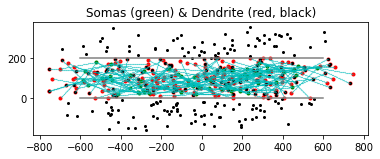

In [15]:
def plot_one_skeleton(soma, pointDend, axes):
    for i in range(pointDend.shape[0]):
        dend_point = pointDend[i, :]
        axes.plot([soma[0], dend_point[0]], [soma[1], dend_point[1]], ':k')

def plot_skeletons(somas, point_dends, axes):
    for s in range(somas.shape[0]):
        soma = somas[s,:2]
        point_dends_1 = point_dends[(s*4):((s+1)*4),:]
        plot_one_skeleton(soma, point_dends_1, axes)
        
figure, axes= plt.subplots(1)

axes.plot(EpointDend[:,0], EpointDend[:,1], 'or', markersize=3)
axes.plot(EpointDendx[:,0], EpointDendx[:,1], 'ok', markersize=2)
axes.plot(somas[:,0],somas[:,1] ,'og', markersize=3)
#plot_skeletons(somas, EpointDend, axes)
axes.plot(xDendAllAll[:], yDendAllAll[:],"oc", markersize=0.1)
    
axes.plot(xlay,up, "grey")
axes.plot(xlay,down, "grey")


axes.set_aspect(1)
plt.title("Somas (green) & Dendrite (red, black)");

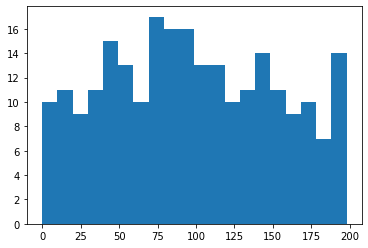

In [16]:
plt.hist(EpointDend[:,1],20);



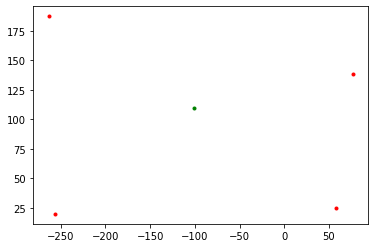

In [17]:
figure, axes= plt.subplots(1)

axes.plot(EpointDend[:4,0], EpointDend[:4,1], 'or', markersize=3)
axes.plot(somas[:1,0],somas[:1,1] ,'og', markersize=3)

## WHAT ABOUT 3D?

In [18]:
#%matplotlib notebook

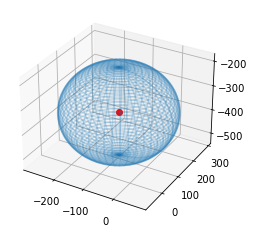

In [19]:
#plotting sphere

phi = np.linspace(0, np.pi, 50)
theta = np.linspace(0, 2*np.pi, 50)
phi, theta = np.meshgrid(phi, theta)

x = np.sin(phi) * np.cos(theta) * Ldend +somas[0,0]
y = np.sin(phi) * np.sin(theta)* Ldend +somas[0,1]
z = np.cos(phi) *Ldend + somas[0,2]


fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, alpha=0.2)
ax.plot(somas[0,0], somas[0,1], somas[0,2],'or')



ax.set_aspect("auto")




plt.show()

### Random perturbation in z-axis

In [20]:
EpointDend.shape

(240, 2)

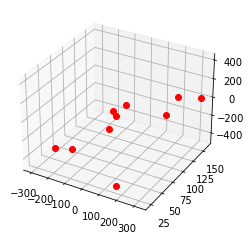

In [22]:
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot(somas[:10,0], somas[:10,1], somas[:10,2],'or')

In [23]:
EpointDend3 = np.zeros((EpointDend.shape[0], 3))
EpointDend3[:, 0:2] = EpointDend
for i in range(somas.shape[0]):
    EpointDend3[(4*i):(4*(i+1)), 2] = somas[i, 2]

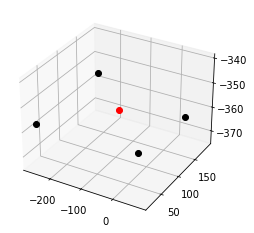

In [24]:
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot(somas[:1,0], somas[:1,1], somas[:1,2],'or')
ax.plot(EpointDend3[:4,0], EpointDend3[:4,1], EpointDend3[:4,2],'ok')
#for ii in range(0,360,1):
 #   ax.view_init(elev=5., azim=ii)
  #  plt.savefig("movie_figs/movie%d.png" % ii)

In [25]:
## 3rd coordinate for Endpoints for only one soma
sigma = 24

ep1 = EpointDend[:4,:] - somas[0,:2]
ep1_3d = np.zeros((4,3))
ep1_3d[:,:2] = ep1
ep1_3d[:, 2] = np.random.randn(4)*sigma


#adjust distance to soma back to Ldend(=180)
for i in range(4):
    norm = np.sqrt(ep1_3d[i,0]**2 + ep1_3d[i,1]**2 + ep1_3d[i,2]**2) 
    ep1_3d[i,:] = ep1_3d[i,:]/norm*Ldend
   

ep1_3d = ep1_3d + somas[0,:]

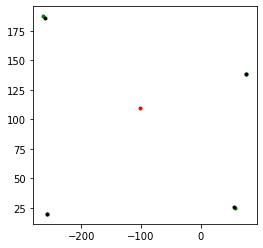

In [26]:
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111)
ax.plot(somas[0,0], somas[0,1],'.r')
ax.plot(EpointDend[:4,0], EpointDend[:4,1],'.g')
ax.plot(ep1_3d[:,0], ep1_3d[:,1],'.k')


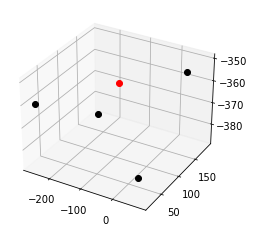

In [27]:
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot(somas[0,0], somas[0,1], somas[0,2],'or')
ax.plot(ep1_3d[:,0], ep1_3d[:,1], ep1_3d[:,2],'ok')

In [104]:
def make_dend_ends_3d(somas, EpointDend):
    ep1_3d_All=np.empty((0,3), dtype=object) #empty array for dendrites
    sigma = 24
    
    for s in range(somas.shape[0]):
        soma = somas[s,:]

        ep1 = EpointDend[(s*4):((s+1)*4),:] - somas[s,:2]
        ep1_3d = np.zeros((4,3))
        ep1_3d[:,:2] = ep1
        ep1_3d[:, 2] = np.random.randn(4)*sigma

        #print(ep1_3d)

        for i in range(4):
            norm = np.sqrt(ep1_3d[i,0]**2 + ep1_3d[i,1]**2 + ep1_3d[i,2]**2)
            ep1_3d[i,:3] = ep1_3d[i,:3]/norm*Ldend
        ep1_3d = ep1_3d[:,:3] + somas[s,:]
        ep1_3d_All=np.append(ep1_3d_All, ep1_3d, axis=0)
        #print(EpointDend[(s*4):((s+1)*4),:])
        
    return ep1_3d_All
    
ep1_3d_All=make_dend_ends_3d(somas, EpointDend)

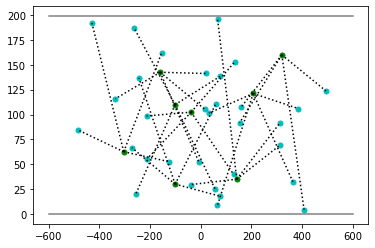

In [29]:
figure, axes= plt.subplots(1)


axes.plot(ep1_3d_All[:32,0], ep1_3d_All[:32,1], 'oc', markersize=5)
axes.plot(somas[:8,0],somas[:8,1],'og', markersize=5)
plot_skeletons(somas[0:8], ep1_3d_All[0:32], axes)
#axes.plot(xDendAllAll[:], yDendAllAll[:],"oc", markersize=0.1)
    
axes.plot(xlay,up, "grey")
axes.plot(xlay,down, "grey")

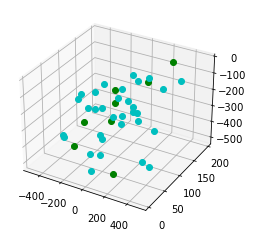

In [30]:
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot(somas[0:8,0], somas[0:8,1], somas[0:8,2],'og')
ax.plot(ep1_3d_All[:32,0], ep1_3d_All[:32,1], ep1_3d_All[:32,2],'oc')
plot_skeletons(somas[0:8], ep1_3d_All[0:32], axes)



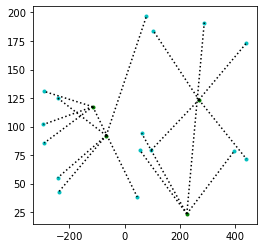

In [31]:
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111)
for s in range(8,12):
    ax.plot(somas[s,0], somas[s,1],'.g')
    #ax.plot(EpointDend[:,0], EpointDend[:,1],'.c')
    ax.plot(ep1_3d_All[(s*4):((s+1)*4),0], ep1_3d_All[(s*4):((s+1)*4),1],'.c')
    for d in range(4):
        ax.plot([somas[s,0], ep1_3d_All[(s*4+d), 0]],
                [somas[s,1], ep1_3d_All[(s*4+d), 1]], ':k')



100%|██████████| 360/360 [00:40<00:00,  8.86it/s]


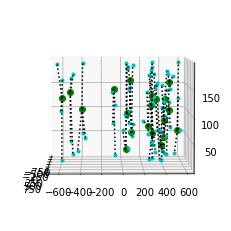

In [34]:
from tqdm import tqdm, trange

fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subpot(111, projection='3d')
for s in range(10,30):
    ax.plot(somas[s,0], somas[s,2], somas[s,1], 'og')
    #ax.plot(EpointDend[:,0], EpointDend[:,1],'.c')
    ax.plot(ep1_3d_All[(s*4):((s+1)*4),0], 
            ep1_3d_All[(s*4):((s+1)*4),2],
            ep1_3d_All[(s*4):((s+1)*4),1], '.c')
    for d in range(4):
        ax.plot([somas[s,0], ep1_3d_All[(s*4+d), 0]],
                [somas[s,2], ep1_3d_All[(s*4+d), 2]],
                [somas[s,1], ep1_3d_All[(s*4+d), 1]], ':k')

for ii in trange(0,360,1):
    ax.view_init(elev=5., azim=ii)
    plt.savefig("movie_figs/movie%d.png" % ii)

/Users/reuschenbachjosefine/ComputationalNeuroscienceUnit/pycabnn-MLI


## Generate Dendrite points

In [43]:
def generate_DendPoint_3d(soma, ep1_3d, nPoint=90):
    DendPointAll= np.empty((0,3),dtype=object)

    for i in range(ep1_3d.shape[0]):
        VectorSoEp= ep1_3d[i]-soma #calculate the vector from soma to endpoint
        for s in range(nPoint):
            DendPoint= np.array(soma+ VectorSoEp/nPoint*s) # vector soma + vectorsomaendpoint shortened
            DendPointAll = np.vstack((DendPointAll,DendPoint))
            
    return DendPointAll

DendPointAll=generate_DendPoint_3d(somas[0], ep1_3d)


100%|██████████| 360/360 [00:15<00:00, 23.74it/s]


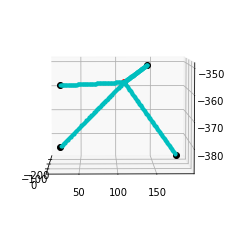

In [44]:
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot(somas[0,0], somas[0,1], somas[0,2],'or')
ax.plot(ep1_3d[:,0], ep1_3d[:,1], ep1_3d[:,2],'ok')
#ax.plot(DendPoint[0], DendPoint[1],DendPoint[2],"oc", markersize=3)
ax.plot(DendPointAll[:,0], DendPointAll[:,1],DendPointAll[:,2],"oc", markersize=3)




for ii in trange(0,360,1):
    ax.view_init(elev=5., azim=ii)
    plt.savefig("movie_figs/movie%d.png" % ii)

(360, 3)

In [36]:
##generate endpoints around respective somas
DendPointAllAll=np.empty((0,3), dtype=object) #empty array for dendrites


for s in range(somas.shape[0]):
    soma = somas[s]
    DendPointAll=(generate_DendPoint_3d(soma,ep1_3d_All[s*4:(s+1)*4]))
    #xDendAll,yDendAll = dend_points_soma_endpoint(point1_xz_new, soma)

    
    DendPointAllAll = np.vstack((DendPointAllAll, DendPointAll))
    #yDendAllAll = np.append(yDendAllAll, yDendAll, axis=0)

100%|██████████| 360/360 [00:22<00:00, 16.27it/s]


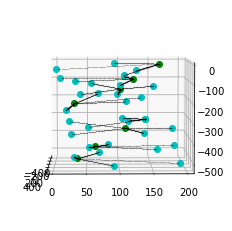

In [48]:
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot(somas[:8,0], somas[:8,1], somas[:8,2],'og')
ax.plot(ep1_3d_All[:32,0], ep1_3d_All[:32,1], ep1_3d_All[:32,2],'oc')
#ax.plot(DendPoint[0], DendPoint[1],DendPoint[2],"oc", markersize=3)
ax.plot(DendPointAllAll[:2880,0], DendPointAllAll[:2880,1],DendPointAllAll[:2880,2],"ok", markersize=0.1)

for ii in trange(0,360,1):
    ax.view_init(elev=5., azim=ii)
    plt.savefig("movie_figs/movie%d.png" % ii)

In [46]:
DendPointAllAll.shape

(21600, 3)

## Adding ID of Soma and Endpoints

In [182]:
def adding_SomaID_to_Epoint(ep1_3d_All, somas):
    """Adding Number of Soma to respective Endpoints"""
    ep1_3d_All_ID = np.zeros((ep1_3d_All.shape[0],4))
    ep1_3d_All_ID[:,:3] = ep1_3d_All
    for i in range(somas.shape[0]):
        ep1_3d_All_ID[i*4:(i+1)*4,3] =i
        
    return ep1_3d_All_ID

ep1_3d_All_ID= adding_SomaID_to_Epoint(ep1_3d_All, somas)

In [181]:
def adding_EPointID_to_Dpoint(DendPointAllAll, ep1_3d_All):
    """Adding Number of Epoint to respective Dendritic Points"""
    DendPointAllAll_ID = np.zeros((DendPointAllAll.shape[0],4))
    DendPointAllAll_ID[:,:3] = DendPointAllAll
    for i in range(ep1_3d_All.shape[0]):
        DendPointAllAll_ID[i*240:(i+1)*240,3] =i
        
    return DendPointAllAll_ID

DendPointAllAll_ID= adding_EPointID_to_Dpoint(DendPointAllAll, ep1_3d_All)

## Running script with Neuron

In [107]:
%load_ext autoreload
%autoreload 2

In [108]:
import pycabnn.cell_population as pop

In [110]:
from neuron import h
h.load_file('test_data/params/Parameters.hoc')

Nseg for APical is 5 and Basal is 3
	36 


1.0

In [112]:
h.MLI_dend_length

180.0

In [113]:
mlipop = pop.MLI_pop(h)

In [120]:
ep1_3d_All = mlipop.gen_dend_endpoints(somas)

In [122]:
ep1_3d_All.shape

(240, 3)